In [46]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from scipy.stats import sem, t
from skopt import gp_minimize

In [38]:
def get_city_coord_dict(filename):
    '''Opens the file with cities and corresponding coordinates. Puts it in an ordered dictionary.
    Input: file name with path.
    Ouput: Ordered dictionary of cities with corresponding x and y coordinates in a numpy array.'''
    city_coord_dict = {}

    with open(filename, 'r') as file:
        for line in file:
            line = line.strip()
            if line[0].isdigit():
                split = line.split()

                city_coord_dict[int(split[0])] = np.array([int(coord) for coord in line.split()[-2:]])

    return OrderedDict(city_coord_dict)

#Open initial file, store cities with coordinates
filename = "TSP-Configurations/eil51.tsp.txt"
init_cities = get_city_coord_dict(filename)

def get_distance(city_a, city_b):
    '''Calculates distance between city a and city b.
    Input: numpy arrays of city_a and city_b coordinates.
    Output: Euclidean distance between the two cities (as a scalar)'''
    return np.linalg.norm(city_a - city_b)

def total_distance(cities):
    '''Calculates the total distance of the route of visiting all cities in order specified.
    Input: OrderedDict of cities (keys) with their coordinates (np.arrays of x and y)
    Output: Total route distance (scalar)'''

    city_coords = list(cities.values())

    #Init variable: link last city with first
    total_distance = get_distance(city_coords[-1], city_coords[0])
    
    #Connect every subsequent pair of cities
    for i in range(len(cities) -1):
        total_distance += get_distance(city_coords[i], city_coords[i+1])

    return total_distance

def visualize_routes(cities):
    '''Visualize the cities on a plane and the routes between cities.
    Input: OrderedDict of cities (keys) and coordinates(values).
    Output: plot of cities and routes between them.
    '''
    city_coords = list(cities.values())
    for city in city_coords:
        plt.scatter(city[0], city[1])

    #Add connecting lines 
    for i in range(len(city_coords) - 1):
        plt.plot([city_coords[i][0], city_coords[i+1][0]], [city_coords[i][1], city_coords[i+1][1]])

    #Connect last city to first
    plt.plot([city_coords[-1][0], city_coords[0][0]], [city_coords[-1][1], city_coords[0][1]])
    plt.show()


# Initial city arrangement

Route distance of initial solutionis : 1313.4683444443463


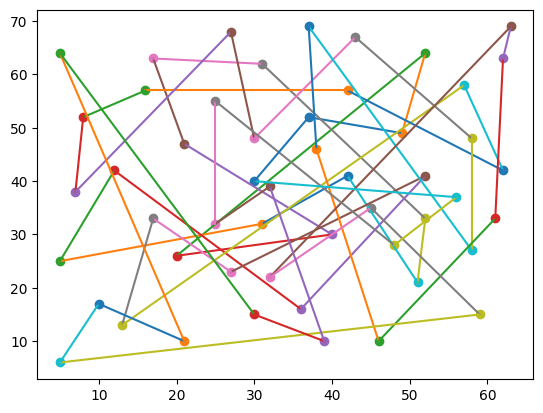

In [39]:
#Get distance of the initial arrangement of cities
init_distance = total_distance(init_cities)
print(f'Route distance of initial solutionis : {init_distance}')
#Visualize initial route arrangement
visualize_routes(init_cities)

In [40]:
class SimulatedAnnealing2opt:
    def __init__(self, cities, C, T0, max_step=100, init_seed=1):
        self.cities_old = cities
        self.C = C
        self.T0 = T0
        self.step = 0
        self.max_step = max_step
        self.seed = init_seed


    def two_opt(self, cities):
        i, j = np.random.choice(len(cities), size=2, replace=False)

        if i > j:
            i, j = j, i

        new_order = list(cities.items())[:i + 1] + list(reversed(list(cities.items())[i + 1:j + 1])) + list(cities.items())[j + 1:]
        return OrderedDict(new_order)
    

    def evaluate(self, cities, proposal_cities, T):
        alpha_func = min(np.exp(-(total_distance(proposal_cities) - total_distance(cities)) / T), 1)
        return alpha_func
    

    def select(self, alpha_func, proposal_cities):
        u = np.random.uniform()
        if u <= alpha_func:
            cities_new = proposal_cities
        else:
            cities_new = self.cities_old
        return cities_new
    

    def run(self):
        while self.step < self.max_step:
            self.seed += 1
            T = (self.C * np.log(self.step + self.T0)) ** (-1)
            self.step += 1

            proposal_cities = self.two_opt(self.cities_old)

            alpha_func = self.evaluate(self.cities_old, proposal_cities, T)
            cities_new = self.select(alpha_func, proposal_cities)
            self.cities_old = cities_new

        return cities_new

# Attempted solution

In [41]:
#Run the simulator
if __name__== '__main__':
    sim_annealing = SimulatedAnnealing2opt(cities = init_cities, C = 0.1, T0 = 0.1, max_step = 50000)
    cities_new = sim_annealing.run()

KeyboardInterrupt: 

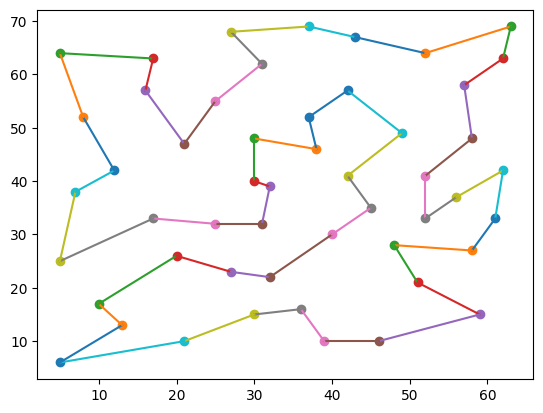

Total distance of simulated annealing (2-opt) solution is: 448.4901170849279
Order of the cities is as follows: odict_keys([1, 32, 27, 51, 46, 12, 47, 18, 13, 25, 14, 24, 43, 7, 23, 6, 48, 8, 26, 31, 28, 3, 36, 35, 20, 29, 16, 9, 50, 21, 34, 30, 49, 10, 39, 33, 45, 15, 44, 42, 40, 19, 41, 4, 17, 37, 5, 38, 11, 2, 22])


In [ ]:
visualize_routes(cities_new)
print(f'Total distance of simulated annealing (2-opt) solution is: {total_distance(cities_new)}')
print(f'Order of the cities is as follows: {cities_new.keys()}')

# Parameter Optimization

In [50]:
param_space = [(0.1, 1, 5, 10, 20), (0.1, 1, 10, 100), (100, 500, 1000, 10000, 50000)] #C, T0, max_steps

In [51]:
def objective_function(params):
    C, T0, max_step = params

    sim_annealing = SimulatedAnnealing2opt(init_cities, C, T0, max_step)
    cities_new = sim_annealing.run()
    distance = total_distance(cities_new)

    return distance

In [52]:
result = gp_minimize(objective_function, param_space, n_calls=50, random_state=42)

# Extract the best parameters
best_params = {
    'C': result.x[0],
    'T0': result.x[1],
    'max_step': int(result.x[2])
}

C:\Users\koenw\AppData\Local\Temp\ipykernel_20180\4093781004.py:38: RuntimeWarning: divide by zero encountered in double_scalars
  T = (self.C * np.log(self.step + self.T0)) ** (-1)
C:\Users\koenw\AppData\Local\Temp\ipykernel_20180\4093781004.py:22: RuntimeWarning: overflow encountered in exp
  alpha_func = min(np.exp(-(total_distance(proposal_cities) - total_distance(cities)) / T), 1)
C:\Users\koenw\AppData\Local\Temp\ipykernel_20180\4093781004.py:22: RuntimeWarning: overflow encountered in exp
  alpha_func = min(np.exp(-(total_distance(proposal_cities) - total_distance(cities)) / T), 1)
c:\Users\koenw\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\koenw\AppData\Local\Temp\ipykernel_20180\4093781004.py:22: RuntimeWarning: overflow encountered in exp
  alpha_func = min(np.exp(-(total_distance(proposal_cities) - tot

In [53]:
# Print the best parameters and the corresponding minimum distance
print("Best Parameters:", best_params)
print("Minimum Distance:", result.fun)

Best Parameters: {'C': 0.1, 'T0': 10.0, 'max_step': 50000}
Minimum Distance: 434.6504770985147
